# MAM02 - Week 2
*Authors*: Robin & Matias

*Status*: Draft

*Date*: 8.10.2024

## Introduction

In this analysis, we aim to investigate the association between 20 risk factors and the occurrence of cardiovascular disease (CVD) events in patients with familial hypercholesterolemia (FH).

In [62]:
# Librarys
# pip install statsmodels
# pip install scikit-learn
# pip install pyreadstat
# pip install pandas
# pip install matplotlib
# pip install seaborn

In [146]:
import pandas as pd

# Load the given data file
data = pd.read_spss("GIRAFH.SAV")

# Some general data descriptions
print(data.head())
print(data.info())
print(data.describe())

      sex  height  weight        bmi alcoholuse smoking  systbp  diasbp  \
0  female   174.0    77.0  25.432686         no    Ever   140.0    95.0   
1    male   179.0    65.0  20.286508        yes    Ever   140.0    95.0   
2    male   183.0    85.0  25.381469        yes    Ever   130.0    85.0   
3  female   169.0    63.0  22.058051        yes    Ever   130.0    75.0   
4    male   176.0    88.0  28.409091        yes   Never   120.0    80.0   

  hypertension  Glucose  ...  diabetes familiarHC     Tc   HDL    Tg    Lpa  \
0          yes      4.7  ...      ever        yes  11.22  1.00  1.40    NaN   
1           no      4.5  ...      ever         no  11.50  1.04  0.81  740.0   
2           no      4.7  ...      ever         no  11.36  1.64  1.67    NaN   
3           no      4.6  ...      ever         no  10.21  1.07  1.18    NaN   
4           no      5.4  ...      ever         no  10.09  1.69  1.01    NaN   

   homocysteine  creatinine        age  event  
0          12.1        75.

In [147]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

sex                0
height           320
weight           205
bmi              342
alcoholuse       491
smoking          234
systbp            37
diasbp            37
hypertension      24
Glucose          118
Hba1c            930
diabetes           0
familiarHC         0
Tc               248
HDL              440
Tg               374
Lpa              702
homocysteine    1306
creatinine        71
age                0
event              0
dtype: int64


# Label encoding 
First the string variables must be encoded. This means the next step for each categorical variable is to transform the string values to numeric ones, that correspond to a unique integer ID representative of each distinct category. This process is called label encoding

In [148]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

def encode_lables(data):
    encoded = data.copy(deep=True)

    for category in categorical_vars:
        encoded[category] = le.fit_transform(encoded[category])
    
    return encoded

# encode data
data = encode_lables(data)  

## Handling Missing Data

*Discarding Missing Values* can lead to losing essential information, especially if missingness is not completely random.

*Chosen Method*: Multiple Imputation

[*Multiple Imputation*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8499698/) preserves the dataset's size by filling in the missing values based on other available data. This is done by regressing the missing values based on the mean of other subjects with similar values in the other variables and pertubing the values with expected variance, thus keeping important factors for analysis. 

*Rationale*: Given the size of the dataset (2,400 patients) and the potential loss of information, we choose multiple imputation to handle missing values. We believe this method allows us to use all available data better and reduce the bias that might result from simply discarding missing values.

In [150]:

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


# for comparison we make a copy of the original data
mi_data = data.copy(deep=True)

# multiple impuation 
mi_imputer_mean = IterativeImputer(initial_strategy="mean", random_state=42)
mi_imputer_freq = IterativeImputer(initial_strategy='most_frequent', random_state=42)

continuous_vars = ['height', 'weight', 'bmi', 'systbp', 'diasbp', 'Glucose', 'Hba1c', 'Tc', 'HDL', 'Tg', 'Lpa', 'homocysteine', 'creatinine', 'age']
categorical_vars = ['sex', 'alcoholuse', 'smoking', 'hypertension', 'diabetes', 'familiarHC', 'event']

mi_data[continuous_vars] = mi_imputer_mean.fit_transform(data[continuous_vars])
mi_data[categorical_vars] = mi_imputer_freq.fit_transform(data[categorical_vars])

In [151]:
# check if the imputation filled the missing data
mi_missing_values = mi_data.isnull().sum()
print(mi_missing_values)

sex             0
height          0
weight          0
bmi             0
alcoholuse      0
smoking         0
systbp          0
diasbp          0
hypertension    0
Glucose         0
Hba1c           0
diabetes        0
familiarHC      0
Tc              0
HDL             0
Tg              0
Lpa             0
homocysteine    0
creatinine      0
age             0
event           0
dtype: int64


## Descriptive Statistics

Compare the means of continuous variables between the event and no-event groups using t-tests to identify significant differences.

In [152]:
from scipy.stats import ttest_ind

# for normal data
event_data = data[data['event'] == 1]
no_event_data = data[data['event'] == 0]

# extract event data for MI_data
mi_event_data = mi_data[mi_data['event'] == 1]
mi_no_event_data = mi_data[mi_data['event'] == 0]


def create_summary_table(var_list, ev_data, no_ev_data):
    # Initialize an empty list to store rows
    rows = []
    for var in var_list:
        event_mean = ev_data[var].mean()
        no_event_mean = no_ev_data[var].mean()
        #  t-test
        t_stat, p_val = ttest_ind(ev_data[var], no_ev_data[var], nan_policy='omit')

        row = {'Variable': var,
               'Event Mean': event_mean,
               'No Event Mean': no_event_mean,
               'P-Value': p_val}

        rows.append(row)

    summary_table = pd.DataFrame(rows)
    return summary_table

# show uncahnged data summary
summary_continuous = create_summary_table(continuous_vars, event_data, no_event_data)
print(summary_continuous)

# show new summary
mi_summary_continuous = create_summary_table(continuous_vars, mi_event_data, mi_no_event_data)
print(mi_summary_continuous)

        Variable  Event Mean  No Event Mean       P-Value
0         height  172.314241     172.536262  6.146797e-01
1         weight   76.665192      74.158866  4.839331e-05
2            bmi   25.752399      24.825277  5.059676e-08
3         systbp  138.270619     133.405797  1.031320e-08
4         diasbp   83.407216      81.182735  1.303249e-06
5        Glucose    5.328681       4.955190  1.095095e-16
6          Hba1c    6.088542       5.642030  6.294341e-11
7             Tc    9.689734       9.463532  1.493702e-02
8            HDL    1.142587       1.238179  4.766208e-08
9             Tg    2.060627       1.693726  1.142556e-13
10           Lpa  440.523540     291.228792  6.664041e-12
11  homocysteine   13.894770      11.668555  7.183053e-05
12    creatinine   84.508409      79.663882  1.019621e-12
13           age   48.419700      46.413791  1.541438e-04
        Variable  Event Mean  No Event Mean       P-Value
0         height  172.376977     172.484190  7.934056e-01
1         weig

For categorical variables, we use chi-squared tests to compare the proportions between the two groups.

In [153]:
from scipy.stats import chi2_contingency

def create_categorical_summary(var_list, ev_data, no_ev_data, d):
    rows = []
    for var in var_list:
        event_counts = ev_data[var].value_counts(normalize=True)
        no_event_counts = no_ev_data[var].value_counts(normalize=True)

        # use the chi for the categorical only
        contingency_table = pd.crosstab(d[var], d['event'])
        chi2, p_val, dof, ex = chi2_contingency(contingency_table)

        row = {'Variable': var,
               'Event Proportion': event_counts.to_dict(),
               'No Event Proportion': no_event_counts.to_dict(),
               'P-Value': p_val}
        rows.append(row)

    summary_table = pd.DataFrame(rows)
    return summary_table

### Create summary for mi_data and data to compare the results

In [154]:
# basic data
summary_categorical = create_categorical_summary(categorical_vars, event_data, no_event_data, data)
print(summary_categorical)


       Variable                                   Event Proportion  \
0           sex     {1: 0.6227621483375959, 0: 0.3772378516624041}   
1    alcoholuse  {1: 0.520460358056266, 2: 0.2659846547314578, ...   
2       smoking  {0: 0.7608695652173914, 1: 0.1585677749360614,...   
3  hypertension  {0: 0.8171355498721228, 1: 0.17135549872122763...   
4      diabetes    {0: 0.8887468030690537, 1: 0.11125319693094629}   
5    familiarHC       {0: 0.840153452685422, 1: 0.159846547314578}   
6         event                                           {1: 1.0}   

                                 No Event Proportion       P-Value  
0    {0: 0.5716934487021014, 1: 0.42830655129789863}  6.255881e-19  
1  {1: 0.6217552533992583, 0: 0.20333745364647712...  2.019825e-07  
2  {0: 0.6199011124845488, 1: 0.27441285537700866...  2.242208e-11  
3  {0: 0.9313967861557478, 1: 0.05933250927070457...  1.906778e-17  
4     {0: 0.9684796044499382, 1: 0.0315203955500618}  7.813679e-15  
5    {0: 0.76637824474660

In [155]:
# mi_data
mi_summary_categorical = create_categorical_summary(categorical_vars, mi_event_data, mi_no_event_data, mi_data)
print(mi_summary_categorical)


       Variable                                   Event Proportion  \
0           sex  {1.0: 0.6227621483375959, 0.0: 0.3772378516624...   
1    alcoholuse  {1.0: 0.520460358056266, 2.0: 0.26598465473145...   
2       smoking  {0.0: 0.7608695652173914, 1.0: 0.1585677749360...   
3  hypertension  {0.0: 0.8171355498721228, 1.0: 0.1713554987212...   
4      diabetes  {0.0: 0.8887468030690537, 1.0: 0.1112531969309...   
5    familiarHC   {0.0: 0.840153452685422, 1.0: 0.159846547314578}   
6         event                                         {1.0: 1.0}   

                                 No Event Proportion       P-Value  
0  {0.0: 0.5716934487021014, 1.0: 0.4283065512978...  6.255881e-19  
1  {1.0: 0.6217552533992583, 0.0: 0.2033374536464...  2.019825e-07  
2  {0.0: 0.6199011124845488, 1.0: 0.2744128553770...  2.242208e-11  
3  {0.0: 0.9313967861557478, 1.0: 0.0593325092707...  1.906778e-17  
4  {0.0: 0.9684796044499382, 1.0: 0.0315203955500...  7.813679e-15  
5  {0.0: 0.76637824474660

## Univariate Logistic Regression Analyses

#### Performing Univariate Analyses

We first need to preprocess the categorical variables so that they're ready for further computation, we need to avoid the current string format of the values.

### We chose logistic regression

Rationale: Linear regression is for regression. Logistic regression for classification. Logistic regression is called a regression nonetheless, since in principle it is very close to the concept of linear regression. The difference is that the linear combination of the feature vector and the coefficient vector βᵀx is then passed through the sigmoid function in order to transform the range of returned values from (-∞, +∞) to [0, 1]. This particularly useful trait makes logistic regression perfect for binary classification tasks which is the case in this one (event: yes/no)


Next, we are going to loop through each predictor variable, build the model, and calculate some results.

In [156]:
import numpy as np
import statsmodels.api as sm
import pandas as pd


def make_univariate_analysis(enc_data):
    univariate_results_list = []
    for var in continuous_vars + categorical_vars:
        if var != 'event':
            model = sm.Logit(enc_data['event'], sm.add_constant(enc_data[var]), missing="drop")
            result = model.fit(disp=0)
            
            odds_ratio = np.exp(result.params.iloc[1])
            p_value = round(result.pvalues.iloc[1], 3)
            if p_value < 0.05:
                p_value = "<0.05*"

            conf = result.conf_int()
            lower_ci = np.exp(conf.iloc[1, 0])
            upper_ci = np.exp(conf.iloc[1, 1])
            
            univariate_results_list.append({'Variable': var,
                                            'Odds Ratio': odds_ratio,
                                            'P-Value': p_value,
                                            '95% CI Lower': lower_ci,
                                            '95% CI Upper': upper_ci})

    results = pd.DataFrame(univariate_results_list)
    return results

In [157]:
# normal univatirate analysis (dropping missing data)
univariate_results = make_univariate_analysis(data)
print(univariate_results)

        Variable  Odds Ratio P-Value  95% CI Lower  95% CI Upper
0         height    0.997436   0.614      0.987521      1.007451
1         weight    1.013916  <0.05*      1.007127      1.020751
2            bmi    1.074854  <0.05*      1.046906      1.103548
3         systbp    1.012754  <0.05*      1.008314      1.017214
4         diasbp    1.020358  <0.05*      1.011993      1.028793
5        Glucose    1.475860  <0.05*      1.333715      1.633155
6          Hba1c    1.335968  <0.05*      1.217825      1.465572
7             Tc    1.057199  <0.05*      1.010804      1.105723
8            HDL    0.434957  <0.05*      0.321495      0.588462
9             Tg    1.392968  <0.05*      1.270409      1.527349
10           Lpa    1.000809  <0.05*      1.000565      1.001052
11  homocysteine    1.045528  <0.05*      1.021562      1.070057
12    creatinine    1.020286  <0.05*      1.014512      1.026092
13           age    1.013578  <0.05*      1.006496      1.020709
14           sex    2.203

In [158]:
# analysis of MI_data
mi_univariate_results = make_univariate_analysis(mi_data)
print(mi_univariate_results)

        Variable  Odds Ratio P-Value  95% CI Lower  95% CI Upper
0         height    0.998785   0.793      0.989741      1.007911
1         weight    1.013163  <0.05*      1.006479      1.019891
2            bmi    1.073483  <0.05*      1.045917      1.101776
3         systbp    1.013042  <0.05*      1.008601      1.017502
4         diasbp    1.020845  <0.05*      1.012468      1.029292
5        Glucose    1.496654  <0.05*      1.351786      1.657048
6          Hba1c    1.437621  <0.05*      1.308226      1.579814
7             Tc    1.058617  <0.05*      1.012627      1.106696
8            HDL    0.415889  <0.05*      0.311461      0.555331
9             Tg    1.422967  <0.05*      1.298796      1.559009
10           Lpa    1.000808  <0.05*      1.000565      1.001052
11  homocysteine    1.056956  <0.05*      1.031885      1.082636
12    creatinine    1.020743  <0.05*      1.014957      1.026563
13           age    1.013578  <0.05*      1.006496      1.020709
14           sex    2.203

## Multivariable Logistic Regression Model


We first include all predictor variables in the multivariable logistic regression model to assess their combined effect on the outcome.

In [159]:
from sklearn.preprocessing import StandardScaler
# TODO
# standardization
def standardize(data):
    scaler = StandardScaler()
    #scaler.fit(data)
    #data = scaler.transform(data)
    
    scaler.fit(data)
    scaled_data = scaler.transform(data)

    return scaled_data

In [165]:
def make_lr_model(enc_data):

    pred = enc_data.drop(columns=['event'])
    #pred = standardize(pred)
    pred = sm.add_constant(pred)

    # Build the logistic regression model
    model = sm.Logit(enc_data['event'], pred, missing="drop")

    return model, pred

In [166]:
mi_model, mi_predictors = make_lr_model(mi_data)
mi_multivar_result = mi_model.fit()

Optimization terminated successfully.
         Current function value: 0.549735
         Iterations 6


In [167]:
model, predictors = make_lr_model(data)
multivar_result = model.fit()

Optimization terminated successfully.
         Current function value: 0.506812
         Iterations 6


#### Checking for Multicollinearity

Multicollinearity among predictors can inflate the variance of coefficient estimates and make the model unstable. We calculate the [VIF](https://en.wikipedia.org/wiki/Variance_inflation_factor) to detect multicollinearity. Variables with VIF > 5 may need to be removed or combined.

In [173]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(predictors):
    vif_data = pd.DataFrame()
    vif_data["feature"] = predictors.columns
    
    # Calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(predictors.values, i)
                       for i in range(len(predictors.columns))]
    return vif_data

In [174]:
vif_data = calc_vif(predictors.dropna())
print(vif_data)

         feature           VIF
0          const  13956.344730
1            sex      2.730428
2         height     41.353812
3         weight    103.104935
4            bmi     68.417899
5     alcoholuse      1.062620
6        smoking      1.080076
7         systbp      1.934892
8         diasbp      1.884615
9   hypertension      1.199593
10       Glucose      1.541655
11         Hba1c      1.181256
12      diabetes      1.455795
13    familiarHC      1.055285
14            Tc      1.064268
15           HDL      1.341626
16            Tg      1.347960
17           Lpa      1.047654
18  homocysteine      1.034840
19    creatinine      1.636336
20           age      1.372552


In [175]:
mi_vif_data = calc_vif(mi_predictors)
print(mi_vif_data)

         feature           VIF
0          const  18873.359346
1            sex      2.105767
2         height     55.740748
3         weight    131.686276
4            bmi     78.792238
5     alcoholuse      1.032253
6        smoking      1.054685
7         systbp      2.018431
8         diasbp      1.923963
9   hypertension      1.125648
10       Glucose      1.582116
11         Hba1c      1.249057
12      diabetes      1.510638
13    familiarHC      1.024519
14            Tc      1.069774
15           HDL      1.289838
16            Tg      1.349377
17           Lpa      1.014313
18  homocysteine      1.049612
19    creatinine      1.551656
20           age      1.371139


### Variance inflation factor
height, weight and bmi have a factor above 5 and therefor should be combined or removed.

## Considering Transformations and Interactions

#### Determining Skewed Variables and Applying Transformations

Skewness refers to the asymmetry in the distribution of a variable. A skewed distribution can impact the performance of regression models, as many statistical techniques assume the normality of the predictors. Transforming skewed variables can help improve model performance.

#### Assessing Skewness

We'll start by doing a visual inspection and then go on to use existing tools to quantify skewness

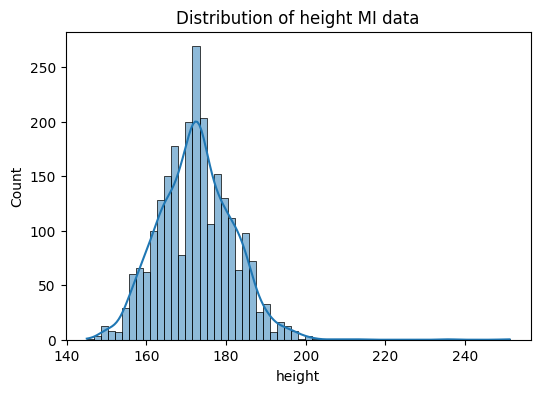

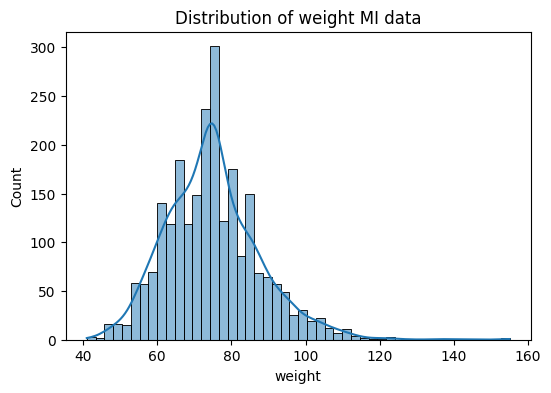

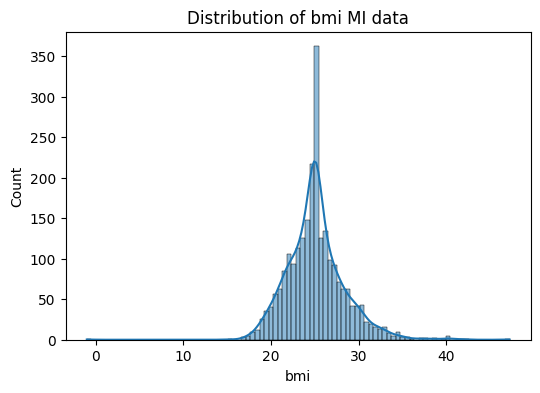

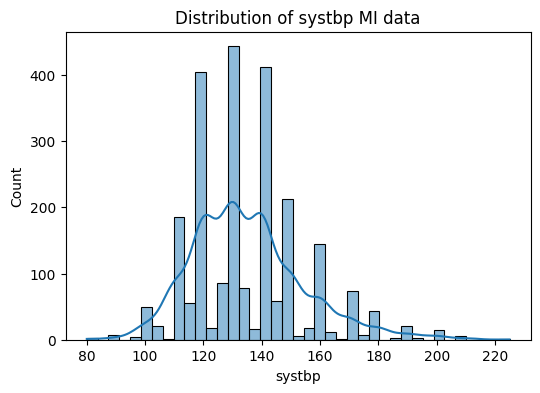

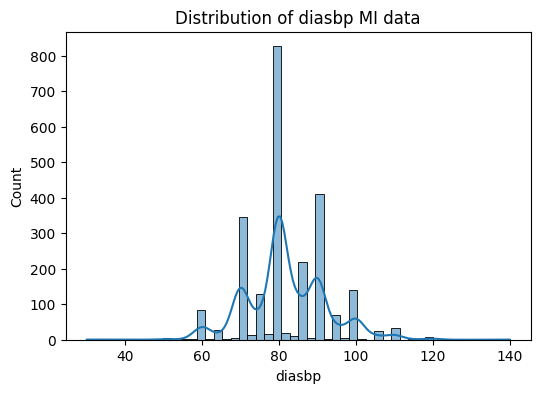

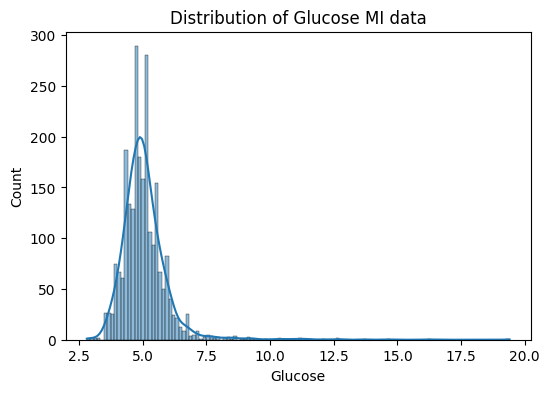

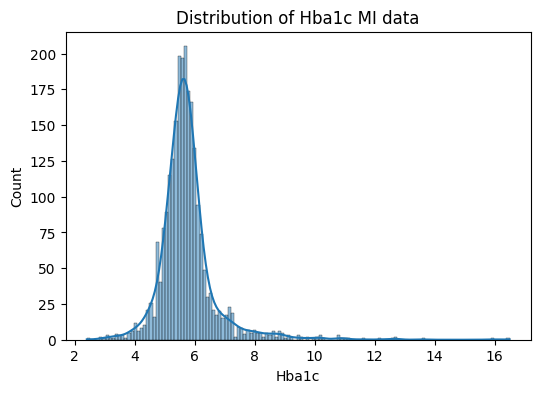

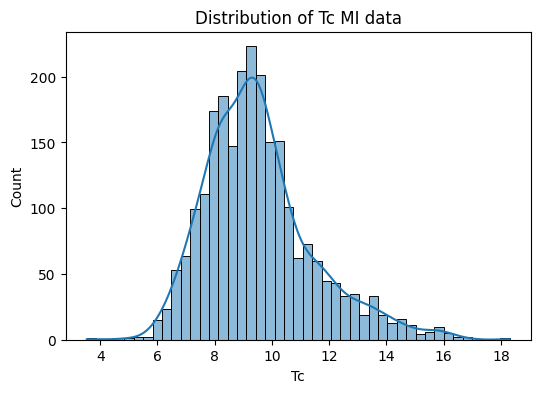

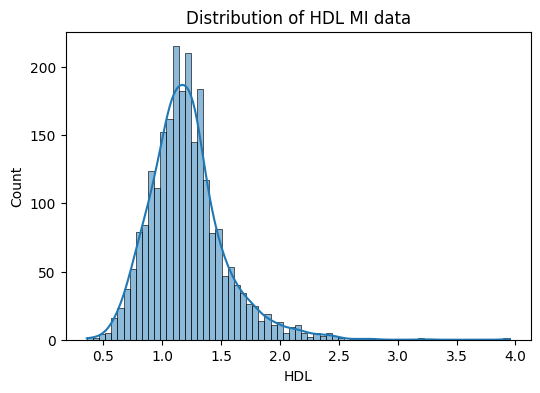

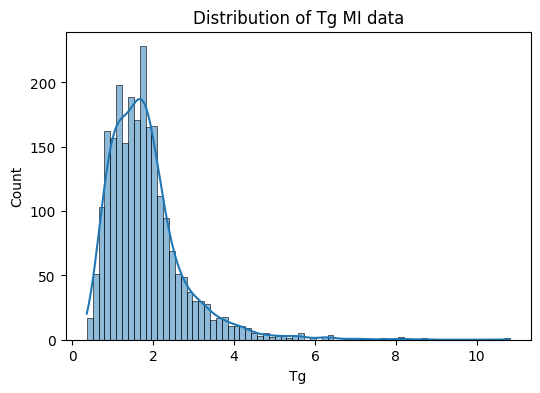

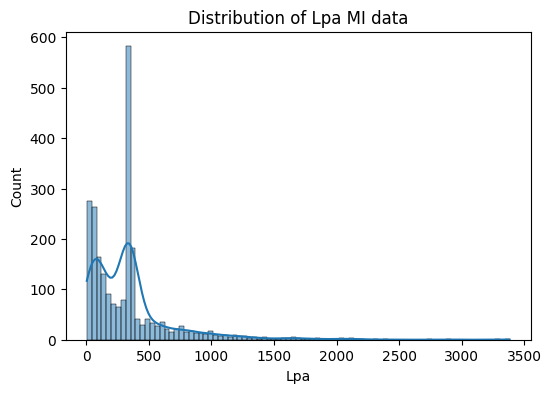

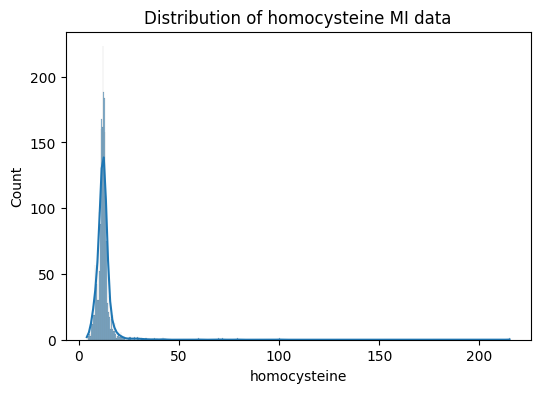

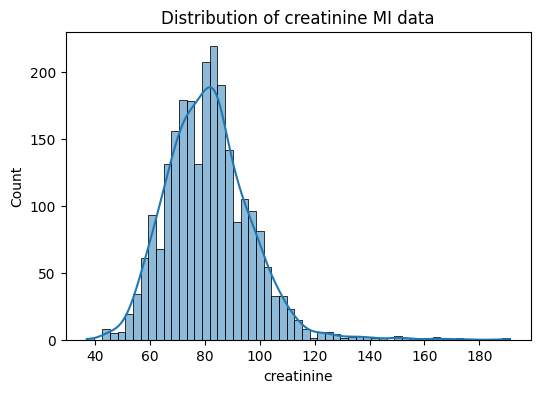

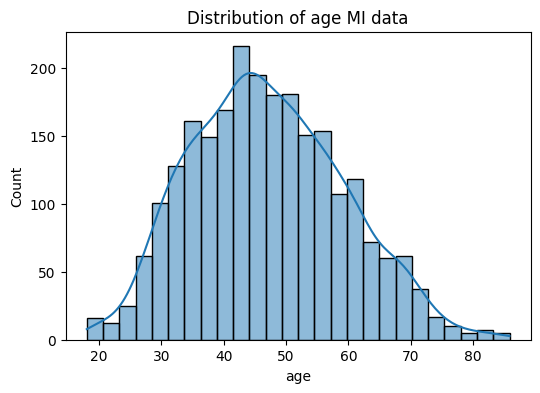

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns


for var in continuous_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(mi_data[var], kde=True)
    plt.title(f'Distribution of {var} MI data')
    plt.show()


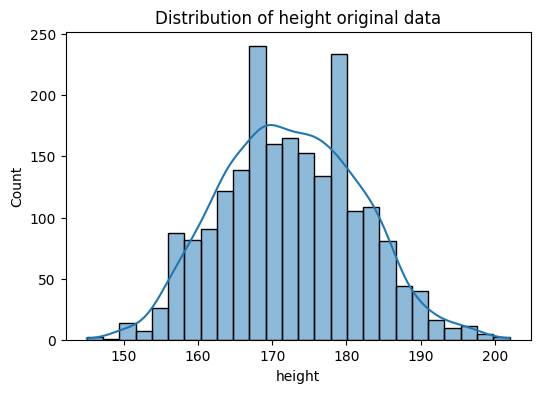

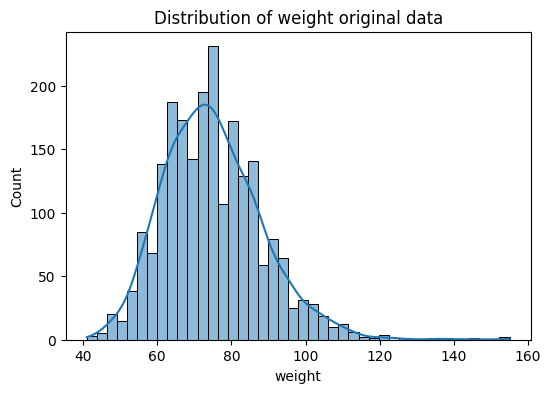

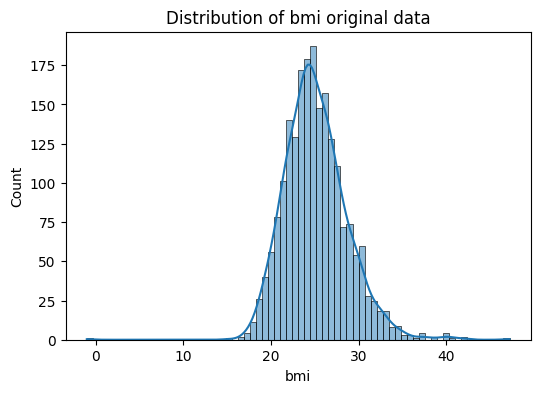

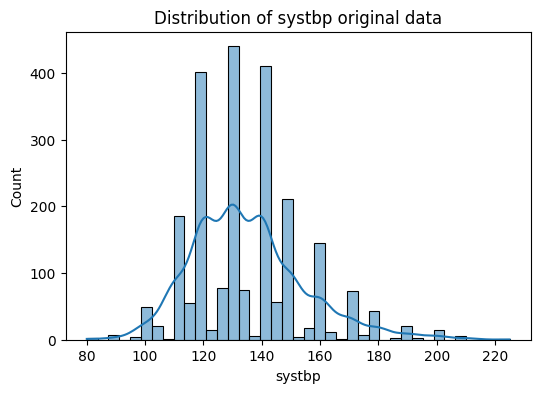

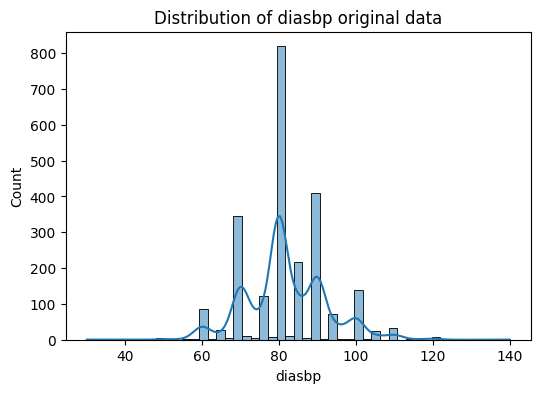

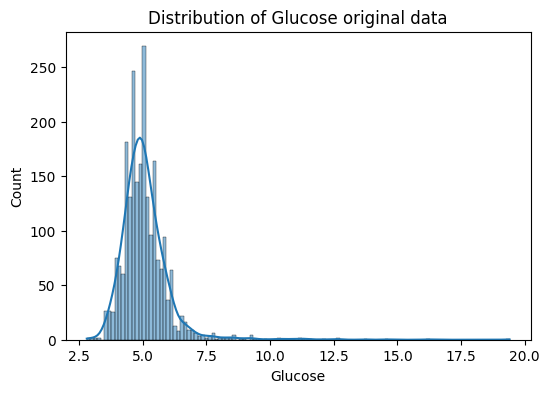

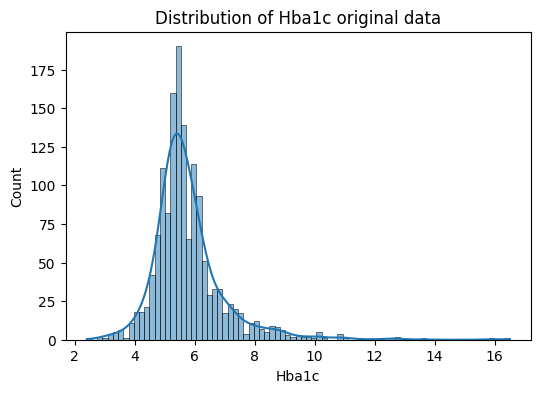

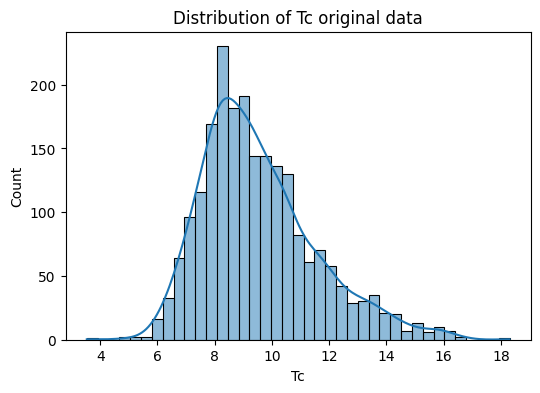

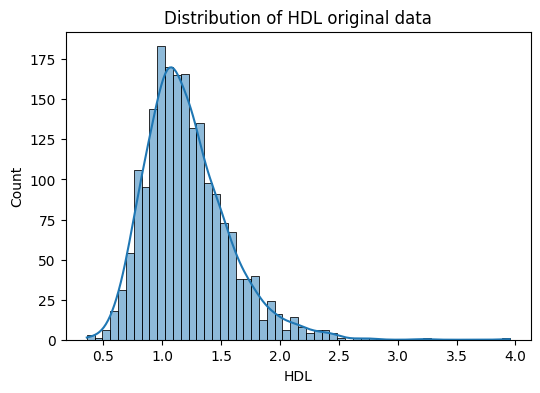

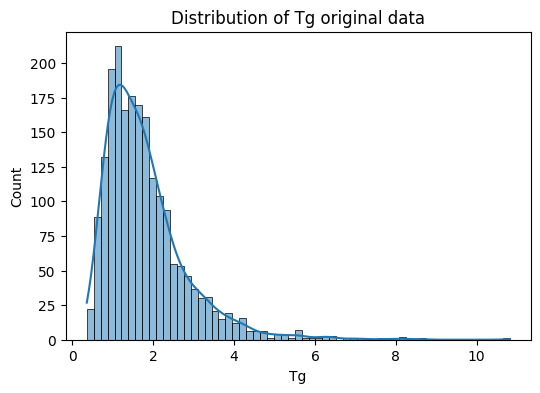

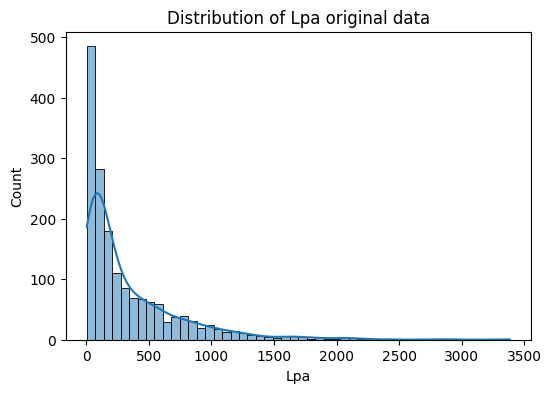

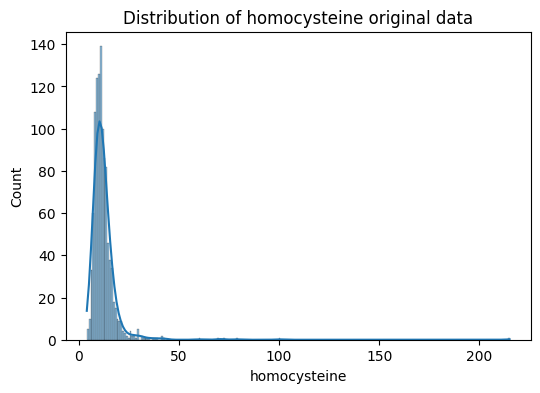

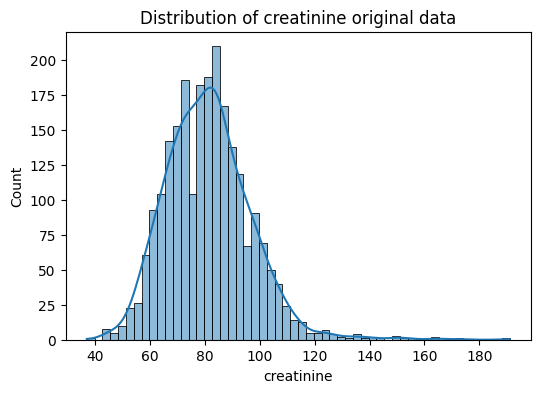

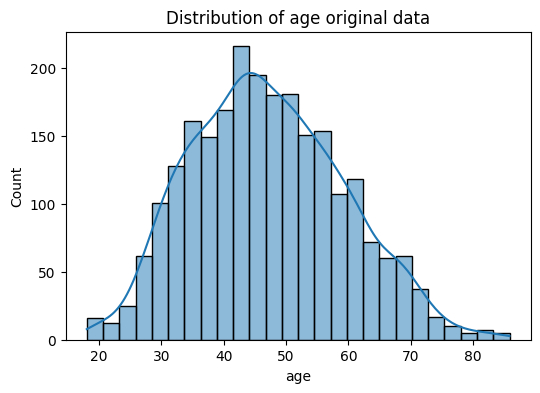

In [177]:
for var in continuous_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[var], kde=True)
    plt.title(f'Distribution of {var} original data')
    plt.show()

In [178]:
from scipy.stats import skew

def get_skewedness(enc_data, continuous_vars):
    skewness_coefficients = {}
    for var in continuous_vars:
        skewness = skew(enc_data[var].dropna())
        skewness_coefficients[var] = skewness
        print(f'Skewness of {var}: {skewness:.2f}')

In [179]:
get_skewedness(data, continuous_vars)

Skewness of height: 0.10
Skewness of weight: 0.75
Skewness of bmi: 0.57
Skewness of systbp: 0.78
Skewness of diasbp: 0.31
Skewness of Glucose: 4.14
Skewness of Hba1c: 2.38
Skewness of Tc: 0.86
Skewness of HDL: 1.13
Skewness of Tg: 2.11
Skewness of Lpa: 2.41
Skewness of homocysteine: 13.15
Skewness of creatinine: 0.88
Skewness of age: 0.27


In [180]:
get_skewedness(mi_data, continuous_vars)

Skewness of height: 0.50
Skewness of weight: 0.78
Skewness of bmi: 0.62
Skewness of systbp: 0.79
Skewness of diasbp: 0.32
Skewness of Glucose: 4.23
Skewness of Hba1c: 2.94
Skewness of Tc: 0.90
Skewness of HDL: 1.21
Skewness of Tg: 2.20
Skewness of Lpa: 2.86
Skewness of homocysteine: 18.95
Skewness of creatinine: 0.90
Skewness of age: 0.27


##### Interpretation
- Skewness ≈ 0: The distribution is approximately symmetric.
- Skewness > 0: The distribution is positively skewed (tail to the right).
- Skewness < 0: The distribution is negatively skewed (tail to the left).
- Thresholds: A skewness coefficient greater than ±1 indicates a highly skewed distribution.

From the result we can determine that Glucose, Hba1c, HDL, Tg, Lpa, and Homocysteine can be considered skewed. Next, we'll apply log transformation which reduces "right skewness" by compressing large values and stretching small values. If the variable contains zero or negative values, we shift the data to make all values positive before applying the log transformation (we don't have any in our data set but for sake of completeness we'll implement it in code).

In [181]:
skewed_vars = ['Glucose', 'Hba1c', 'HDL', 'Tg', 'Lpa', 'homocysteine']

def log_transformation(skewed_vars, enc_data):
    for var in skewed_vars:
        # Check for non-positive values
        if (enc_data[var] <= 0).any():
            # If yes -> shift
            min_value = enc_data[var].min()
            enc_data[var + '_log'] = np.log(enc_data[var] - min_value + 1)
        else:
            enc_data[var + '_log'] = np.log(enc_data[var] + 1)

# perform transformation
log_transformation(skewed_vars, data)
log_transformation(skewed_vars, mi_data)

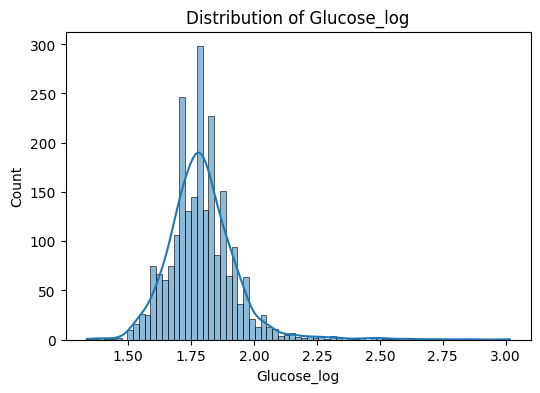

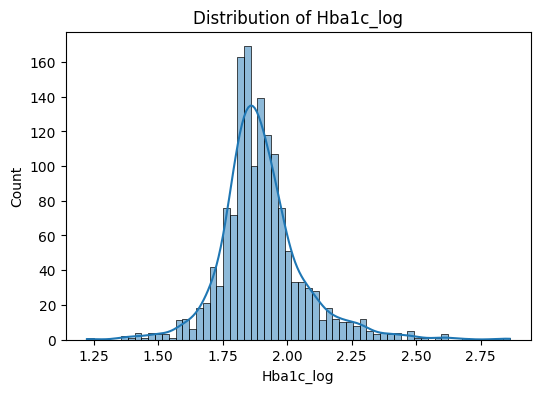

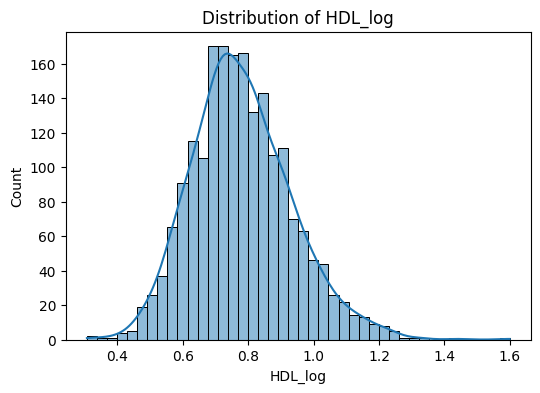

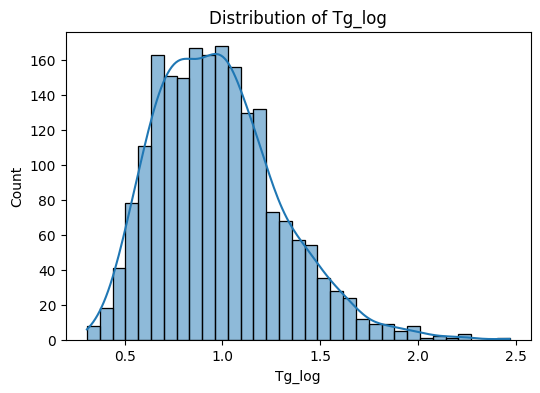

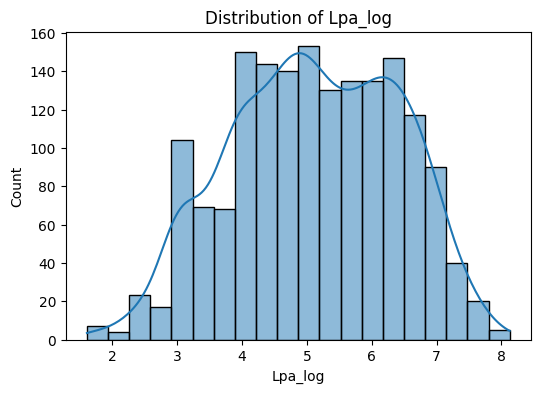

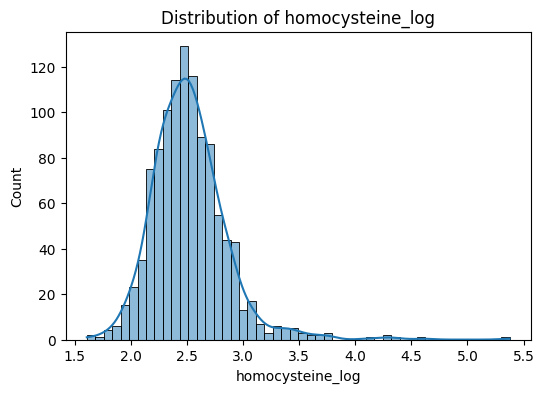

In [182]:
# show the plots
for var in skewed_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(data_encoded[var + '_log'], kde=True)
    plt.title(f'Distribution of {var}_log')
    plt.show()


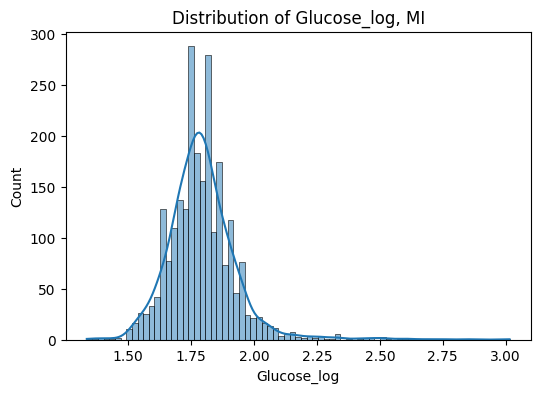

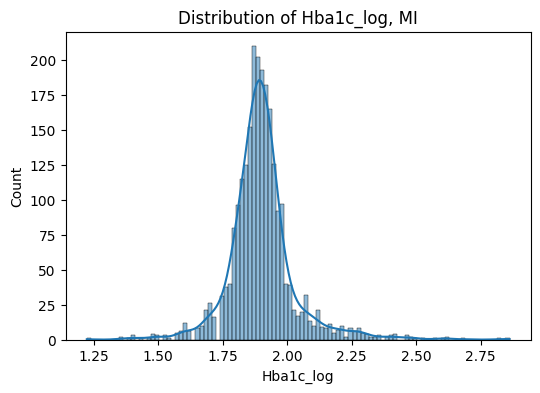

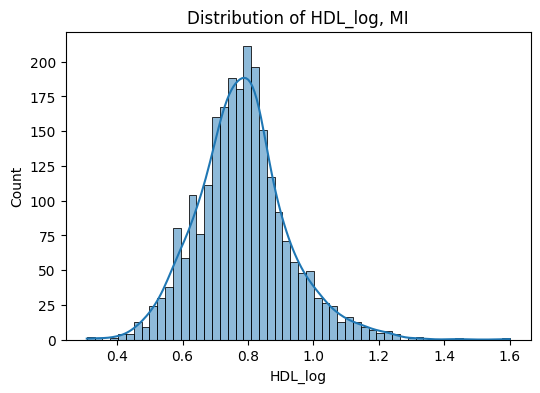

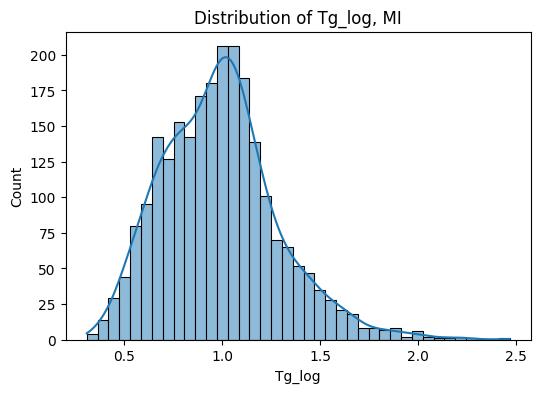

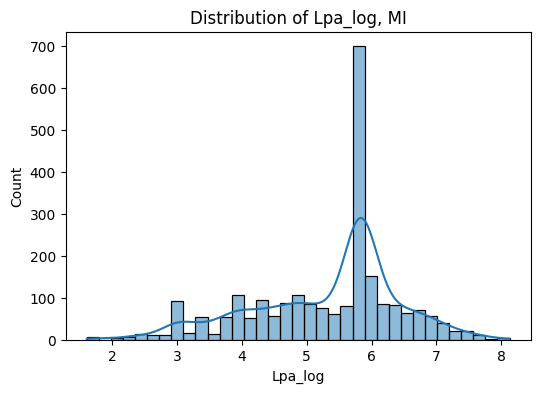

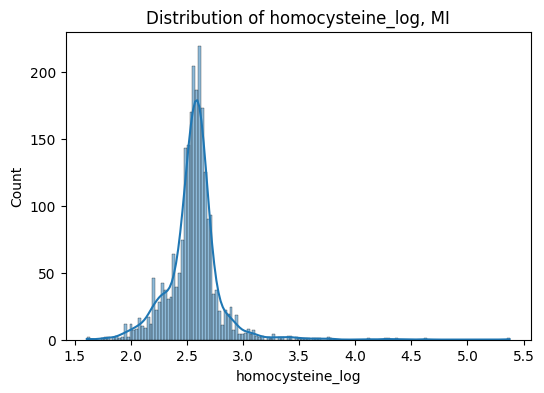

In [183]:
for var in skewed_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(mi_data[var + '_log'], kde=True)
    plt.title(f'Distribution of {var}_log, MI')
    plt.show()

In [184]:
# Update continuous variables
continuous_vars_transformed = [var + '_log' if var in skewed_vars else var for var in continuous_vars]
print(continuous_vars_transformed)


['height', 'weight', 'bmi', 'systbp', 'diasbp', 'Glucose_log', 'Hba1c_log', 'Tc', 'HDL_log', 'Tg_log', 'Lpa_log', 'homocysteine_log', 'creatinine', 'age']


In [185]:
# updated
get_skewedness(mi_data, continuous_vars_transformed)

Skewness of height: 0.50
Skewness of weight: 0.78
Skewness of bmi: 0.62
Skewness of systbp: 0.79
Skewness of diasbp: 0.32
Skewness of Glucose_log: 1.73
Skewness of Hba1c_log: 1.15
Skewness of Tc: 0.90
Skewness of HDL_log: 0.47
Skewness of Tg_log: 0.65
Skewness of Lpa_log: -0.63
Skewness of homocysteine_log: 1.79
Skewness of creatinine: 0.90
Skewness of age: 0.27


In [186]:
# original
get_skewedness(mi_data, continuous_vars)

Skewness of height: 0.50
Skewness of weight: 0.78
Skewness of bmi: 0.62
Skewness of systbp: 0.79
Skewness of diasbp: 0.32
Skewness of Glucose: 4.23
Skewness of Hba1c: 2.94
Skewness of Tc: 0.90
Skewness of HDL: 1.21
Skewness of Tg: 2.20
Skewness of Lpa: 2.86
Skewness of homocysteine: 18.95
Skewness of creatinine: 0.90
Skewness of age: 0.27


### Skewedness change
Since normality is assumed for further analysis, we updated the continuous vars. 

* Skewness of Glucose: 4.23 -> 1.73
* Skewness of Hba1c: 2.94 -> 1.15
* Skewness of HDL: 1.21 -> 0.47
* Skewness of Tg: 2.20 -> 0.65
* Skewness of Lpa: 2.86 -> -0.63
* Skewness of homocysteine: 18.95 -> 1.79

The skewness is way better
Glucose, Hba1c and homocysteine is still >1 but way closer to the target of ~+-1

#### Identifying Potential Interactions Between Variables

An interaction occurs when the effect of one predictor variable on the outcome depends on the level of another predictor variable. Including interaction terms in the model can improve predictive accuracy if such relationships exist.

Way to identify interactions:
- Domain Knowledge (For example, the effect of systolic blood pressure on CVD risk may differ between males and females.)
- Exploratory Data Analysis (EDA) E.g. Plot the relationship between predictors and the outcome, stratified by another variable.) Example: Plotting CVD event rates against blood pressure for males and females separately.
- Statistical Tests. Include interaction terms (Multiply two predictor variables together.) in the model and test their significance.

In [188]:
# interaction terms
#import shap

def get_interaction(enc_data, var1, var2):
    name = var1 + '_' + var2 + '_interaction'
    enc_data[name] = enc_data[var1] * enc_data[var2]

    interaction_predictors = [name] + continuous_vars_transformed + categorical_vars

    x = enc_data[interaction_predictors].drop(columns=['event'])
    y = enc_data['event']
    
    x = sm.add_constant(x)
    
    interaction_model = sm.Logit(y, x, missing="drop")
    interaction_result = interaction_model.fit()

    #explainer = shap.LinearExplainer(interaction_result.predict, x)
    # = explainer(X)
    
    # make a standard partial dependence plot
    #sample_ind = 20
    #shap.partial_dependence_plot(
    #    "MedInc",
    #    model.predict,
    #    x,
    #    model_expected_value=True,
    #    feature_expected_value=True,
    #    ice=False,
    #    shap_values=shap_values[sample_ind : sample_ind + 1, :],
    #)

    return interaction_model, interaction_result

# pairs of interactions we test
interactions_to_test = [
    ['sex', 'systbp'],
    ['age', 'diabetes'],
    ['smoking', 'HDL'],
]

# execute it
for interaction in interactions_to_test:
    model, result = get_interaction(data, interaction[0], interaction[1])
    print('Interaction of ' + interaction[0] + ' and ' + interaction[1] + ' normal data')
    print(result.summary())
    
    mi_model, mi_result = get_interaction(mi_data, interaction[0], interaction[1])
    print('Interaction of ' + interaction[0] + ' and ' + interaction[1] + ' MI data')
    print(mi_result.summary())
    

Optimization terminated successfully.
         Current function value: 0.511274
         Iterations 6
Interaction of sex and systbp normal data
                           Logit Regression Results                           
Dep. Variable:                  event   No. Observations:                  696
Model:                          Logit   Df Residuals:                      674
Method:                           MLE   Df Model:                           21
Date:                Sun, 13 Oct 2024   Pseudo R-squ.:                  0.1617
Time:                        15:30:18   Log-Likelihood:                -355.85
converged:                       True   LL-Null:                       -424.48
Covariance Type:            nonrobust   LLR p-value:                 4.453e-19
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.4959     10.9

# Results from interactions
age_diabetes_interaction   significant p=0.021
One way we could make it better the interactions can be explored like in this [article](https://developer.nvidia.com/blog/a-comprehensive-guide-to-interaction-terms-in-linear-regress)

P-value indicates that the effect of systolic blood pressure on the risk of a CVD event DOES NOT differ between males and females.


Let's try a few more just for fun.


No significance, we shall move on.


#### Rebuilding the Model with Transformations (and Interactions if we had any)


In [190]:
# Rebuild the logistic regression model
def build_lr_model(enc_data):
    pred = continuous_vars_transformed + categorical_vars
    
    x = enc_data[pred].drop(columns=['event'])
    y = enc_data['event']
    
    x = sm.add_constant(x)
    
    model = sm.Logit(y, x, missing='drop')
    result = model.fit()
    return model, resultd_lr_model(mi_data)
print(mi_result_transformed.summary())

print('original data results')
model_transformed, result_transformed = build_lr_model(data)
print(result_transformed.summary())

print('MI data results')
mi_model_transformed, mi_result_transformed = buil

original data results
Optimization terminated successfully.
         Current function value: 0.512162
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  event   No. Observations:                  696
Model:                          Logit   Df Residuals:                      675
Method:                           MLE   Df Model:                           20
Date:                Sun, 13 Oct 2024   Pseudo R-squ.:                  0.1602
Time:                        15:47:24   Log-Likelihood:                -356.46
converged:                       True   LL-Null:                       -424.48
Covariance Type:            nonrobust   LLR p-value:                 2.851e-19
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.4516     10.885      0.317      0.751     -17.883  

## Evaluating Model Performance

In [191]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

predictors = continuous_vars_transformed + categorical_vars

def eval_model_performance(enc_data, predictors):
    x = enc_data[predictors].drop(columns=['event'])

    X_train, X_test, y_train, y_test = train_test_split(x, enc_data['event'], test_size=0.3, random_state=42)
    
    model = sm.Logit(y_train, X_train, missing='drop')
    result = model.fit()
    
    # predict probabilities
    y_pred_prob = result.predict(X_test)

    # predict classes
    y_pred_class = [1 if x > 0.5 else 0 for x in y_pred_prob]
    
    # confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    print(conf_matrix)
    
    # classification report
    class_report = classification_report(y_test, y_pred_class)
    print(class_report)
    
    # roc and auc
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Optimization terminated successfully.
         Current function value: 0.527843
         Iterations 6
[[131  16]
 [ 33  29]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       147
           1       0.64      0.47      0.54        62

    accuracy                           0.77       209
   macro avg       0.72      0.68      0.69       209
weighted avg       0.75      0.77      0.75       209



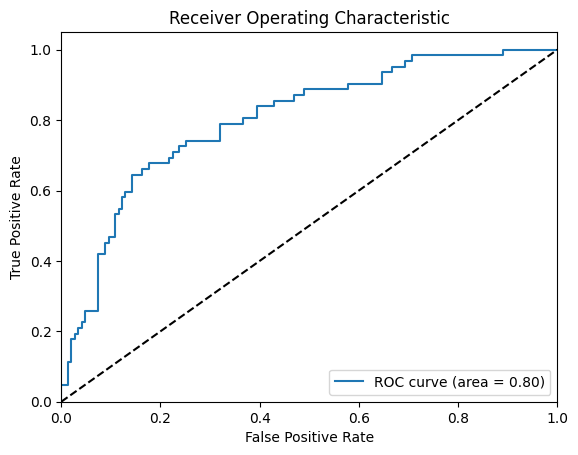

In [83]:
eval_model_performance(data.dropna(), predictors)

Optimization terminated successfully.
         Current function value: 0.556229
         Iterations 6
[[446  49]
 [141  84]]
              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82       495
         1.0       0.63      0.37      0.47       225

    accuracy                           0.74       720
   macro avg       0.70      0.64      0.65       720
weighted avg       0.72      0.74      0.71       720



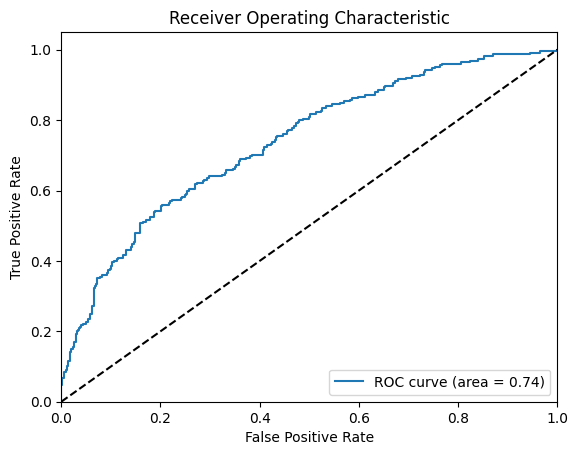

In [84]:
eval_model_performance(mi_data, predictors)

##### TODO: Some analysis

## Variable Selection
#### Applying LASSO Regression
LASSO regression performs variable selection by penalizing the absolute size of the coefficients.

In [236]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel

def lasso_regression(enc_data, predictors):
    # split for train and test
    x = enc_data[predictors].drop(columns=['event'])
    X_train, X_test, y_train, y_test = train_test_split(x, enc_data['event'], test_size=0.3, random_state=42)
    
    # standardize the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    sel_ = SelectFromModel(LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))
    sel_.fit(scaler.transform(X_train), y_train)

    # get removed features
    removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    print(removed_feats)

    # new set set of training data
    X_train_selected = sel_.transform(scaler.transform(X_train))
    X_test_selected = sel_.transform(scaler.transform(X_test))
    
    print(X_train_selected.shape, X_test_selected.shape)

    # train new model with selected data
    model = sm.Logit(y_train, X_train_selected, missing='drop')
    result = model.fit()
    
    # predict probabilities
    y_pred_prob = result.predict(X_test_selected)

    # predict classes
    y_pred_class = [1 if x > 0.5 else 0 for x in y_pred_prob]
    
    # confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    print(conf_matrix)
    
    # classification report
    class_report = classification_report(y_test, y_pred_class)
    print(class_report)
    
    # roc and auc
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Index(['weight', 'systbp', 'alcoholuse'], dtype='object')
(487, 17) (209, 17)
Optimization terminated successfully.
         Current function value: 0.625319
         Iterations 5
[[88 59]
 [10 52]]
              precision    recall  f1-score   support

           0       0.90      0.60      0.72       147
           1       0.47      0.84      0.60        62

    accuracy                           0.67       209
   macro avg       0.68      0.72      0.66       209
weighted avg       0.77      0.67      0.68       209



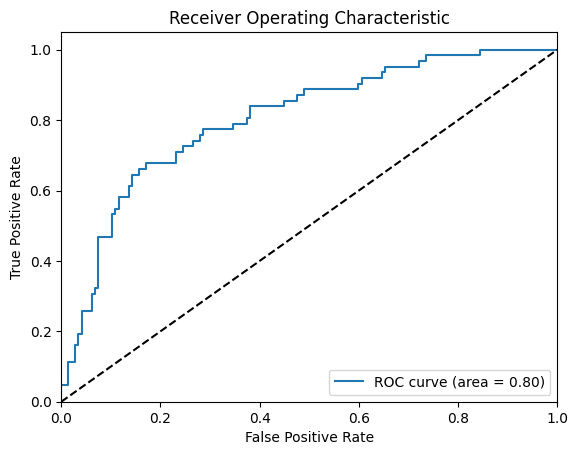

In [237]:
selected_vars = lasso_regression(data.dropna(), predictors)

Index(['weight'], dtype='object')
(1680, 19) (720, 19)
Optimization terminated successfully.
         Current function value: 0.622099
         Iterations 5
[[323 172]
 [ 73 152]]
              precision    recall  f1-score   support

         0.0       0.82      0.65      0.73       495
         1.0       0.47      0.68      0.55       225

    accuracy                           0.66       720
   macro avg       0.64      0.66      0.64       720
weighted avg       0.71      0.66      0.67       720



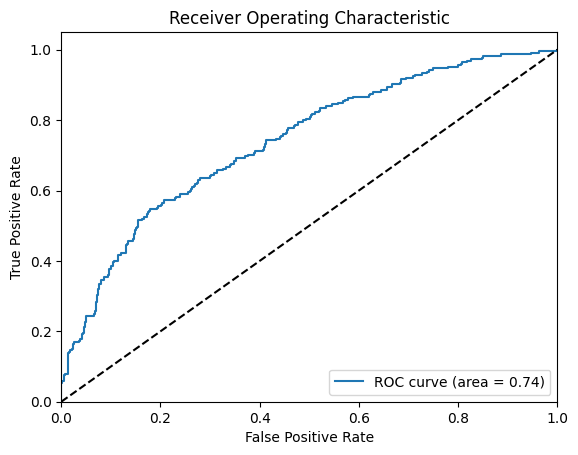

In [238]:
mi_selected_vars = lasso_regression(mi_data, predictors)

Same columns, we could try a different methods such as backward elimination based on p-values or forward selection